# TS8: Filtrado digital lineal de ECG


### Autoras: Angelina Fantauzzo Fabio y Noelia Ferrari


#### **INTRODUCCIÓN** 

El procesamiento de señales de Electrocardiograma (ECG) es una aplicación crucial en la ingeniería biomédica, donde la precisión es fundamental.

Las señales de ECG suelen estar contaminadas por diversas interferencias de baja frecuencia, como la deriva de la línea de base (causada por movimientos del paciente o cambios en la polarización de los electrodos), y ruido de alta frecuencia.

Para cumplir con las consignas, se abordarán dos familias de filtros con propiedades distintas:

**Filtros FIR (Respuesta de Impulso Finita):** Diseñados mediante las metodologías de Ventanas (Kaiser), Mínimos Cuadrados (FIRLS) y Equiripple (Remez). Estos filtros garantizan fase lineal, esencial para no distorsionar la morfología de la onda P-QRS-T.

**Filtros IIR (Respuesta de Impulso Infinita):** Diseñados con las aproximaciones de Butterworth, Chebychev I y Cauer. Estos filtros destacan por su eficiencia en el orden, pero presentan el desafío de la fase no lineal.

#### **DESARROLLO** 

**a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.**

Ayuda: Utilice los resultados del ancho de banda estimado del ECG en la Tarea Semanal 5. Tome como referencia las siguientes morfologías promedio para evaluar cualitativamente la efectividad de los filtros diseñados.

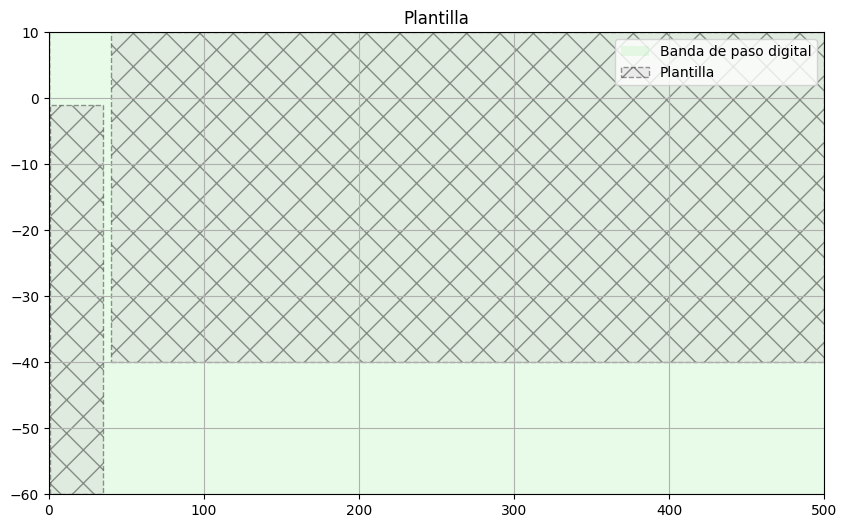

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as sio
from scipy import signal 


#PLANTILLA
fs=1000 #Hz
wp = np.array([0.8, 35])  # frecuencia de corte/paso (rad/s) 
ws= np.array([0.1, 40])       
ripple = 1                         
attenuation = 40  

fig = plt.figure(figsize=(10, 6))
plt.title('Plantilla')
plt.grid(which='both', axis='both')
plt.xlim([0, 500])
plt.ylim([-60, 10]) 
plot_plantilla(filter_type='bandpass',fpass=wp,ripple=ripple,fstop=ws,attenuation=attenuation,fs=fs)
plt.legend()
plt.show()


**b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.**



Los valores que utilizamos fueron los siguientes:

Frecuencia de paso: [0.8, 35.0] Hz

Frecuencia de stop: [0.1, 40]   Hz

Ripple: 1dB

Atenuación: 40dB

En la TS5 el ancho de banda de la ECG nos había dado 17Hz por lo que una frecuencia de corte de 35Hz es suficiente para preservar la información.
Además al atenuar las frecuencias superiores a 35Hz, se eliminan componentes de alta frecuencia del ruido muscular por lo que se cumple uno de los requisitos del ítem a) que era la suavidad del trazo.

La frecuencia de stop superior de 40Hz nos permite una transición rápida desde la banda de paso y asegura que el ruido muscular de alta frecuencia sea atenuado eficazmente.

**c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.**


#### **FIR**

FIR Kaiser Conv. Orden: 2260
FIR Remez Conv. Orden: 2260
FIR Least Squares Conv. Orden: 2260


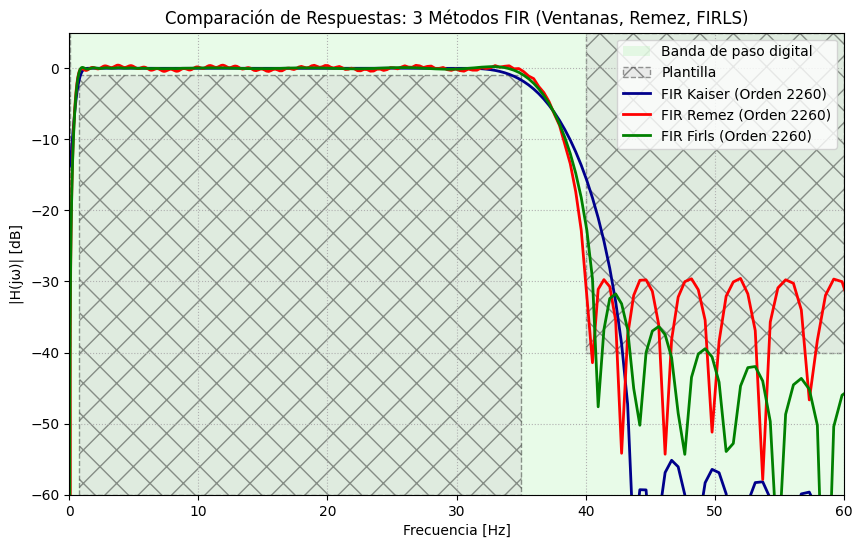

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from pytc2.sistemas_lineales import plot_plantilla 

fs = 1000 # Hz
wp = np.array([0.8, 35])    # Frecuencia de paso 
ws = np.array([0.1, 40])    # Frecuencia de stop 
gpass = 1.0                 
gstop = 40.0                
nyq_rate = fs / 2

# Órdenes para el diseño FIR por convolución (Aseguramos impar para Remez/FIRLS)
orden_base_hp = 2000
orden_base_lp = 260
orden_hp = orden_base_hp + (orden_base_hp % 2 == 0) 
orden_lp = orden_base_lp + (orden_base_lp % 2 == 0) # 


#DISEÑO DE FIR CON MÉTODO DE VENTANAS (Kaiser) POR CONVOLUCIÓN

# Usaremos Kaiser con un beta para atenuación de 40dB (beta ~ 3.39) 
beta_kaiser = 3.39 

frecs_hp = [0, ws[0], wp[0], nyq_rate]
gains_hp_kaiser = [0, 0, 1, 1] 
fir_kaiser_hp = sig.firwin2(orden_hp, frecs_hp, gains_hp_kaiser, window=('kaiser', beta_kaiser), fs=fs)

frecs_lp = [0, wp[1], ws[1], nyq_rate]
gains_lp_kaiser = [1, 1, 0, 0]
fir_kaiser_lp = sig.firwin2(orden_lp, frecs_lp, gains_lp_kaiser, window=('kaiser', beta_kaiser), fs=fs)

# Convolución para Pasa-Banda final
fir_kaiser_bandpass = np.convolve(fir_kaiser_hp, fir_kaiser_lp)
orden_final_kaiser = len(fir_kaiser_bandpass) - 1
w_kaiser, h_kaiser_bp = sig.freqz(b=fir_kaiser_bandpass, a=1.0, worN=np.logspace(-2, np.log10(fs/2), 1000), fs=fs)
h_db_kaiser_bp = 20 * np.log10(np.abs(h_kaiser_bp))
print(f"FIR Kaiser Conv. Orden: {orden_final_kaiser}")


# DISEÑO DE FIR REMEZ POR CONVOLUCIÓN

bands_hp = [0, ws[0], wp[0], nyq_rate]    
desired_hp = [0, 1]                   
fir_remez_hp = sig.remez(numtaps=orden_hp, bands=bands_hp, desired=desired_hp, fs=fs)

bands_lp = [0, wp[1], ws[1], nyq_rate]   
desired_lp = [1, 0]                    
fir_remez_lp = sig.remez(numtaps=orden_lp, bands=bands_lp, desired=desired_lp, fs=fs)

fir_remez_bandpass = np.convolve(fir_remez_hp, fir_remez_lp)
orden_final_remez = len(fir_remez_bandpass) - 1
w_remez, h_remez_bp = sig.freqz(b=fir_remez_bandpass, a=1.0, worN=w_kaiser, fs=fs) 
h_db_remez_bp = 20 * np.log10(np.abs(h_remez_bp))
print(f"FIR Remez Conv. Orden: {orden_final_remez}")


# DISEÑO DE FIR LEAST SQUARES (FIRLS) POR CONVOLUCIÓN

frecs_hp_firls = [0, ws[0], wp[0], nyq_rate]
ganancias_hp_firls = [0, 0, 1, 1] 
fir_firls_hp = sig.firls(orden_hp, frecs_hp_firls, ganancias_hp_firls, fs=fs)

frecs_lp_firls = [0, wp[1], ws[1], nyq_rate]
ganancias_lp_firls = [1, 1, 0, 0] 
fir_firls_lp = sig.firls(orden_lp, frecs_lp_firls, ganancias_lp_firls, fs=fs)

fir_firls_bandpass = np.convolve(fir_firls_hp, fir_firls_lp)
orden_final_firls = len(fir_firls_bandpass) - 1
w_firls, h_firls_bp = sig.freqz(b=fir_firls_bandpass, a=1.0, worN=w_kaiser, fs=fs)
h_db_firls_bp = 20 * np.log10(np.abs(h_firls_bp))
print(f"FIR Least Squares Conv. Orden: {orden_final_firls}")


plt.figure(figsize=(10, 6))
plt.title('Comparación de Respuestas: 3 Métodos FIR (Ventanas, Remez, FIRLS)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')
plt.xlim([0, 60])
plt.ylim([-60, 5])

plot_plantilla(
    filter_type='bandpass',
    fpass=wp,
    ripple=gpass,
    fstop=ws,
    attenuation=gstop,
    fs=fs
)

# 1. FIR Kaiser (Ventanas)
plt.plot(w_kaiser, h_db_kaiser_bp, color='darkblue', linewidth=2, label=f'FIR Kaiser (Orden {orden_final_kaiser})')

# 2. FIR Remez
plt.plot(w_remez, h_db_remez_bp, color='red', linewidth=2, label=f'FIR Remez (Orden {orden_final_remez})')

# 3. FIR Least Squares
plt.plot(w_firls, h_db_firls_bp, color='green', linewidth=2, label=f'FIR Firls (Orden {orden_final_firls})')


plt.legend(loc='upper right')
plt.show()

El gráfico compara los tres filtros FIR con un orden de 2260. Este alto orden fue necesario para lograr la  transición requerida entre 0.1Hz y 0.8Hz, un costo computacional que es la principal desventaja de los FIR al contrastarlos con los IIR (que logran el mismo objetivo con órdenes mucho más bajos).

A pesar de su costo similar, los filtros difieren en cómo manejan el error:

El filtro Remez (rojo) se comporta de forma equiripple, utilizando el ripple máximo permitido 1dB en la banda de paso y acercándose al límite de -40dB en la banda de rechazo. 

Por otro lado, el filtro Kaiser es el más suave, presentando el ripple más bajo en la banda de paso y la atenuación más profunda en la banda de rechazo. Firls ocupa un punto intermedio, ofreciendo una atenuación en rechazo superior a Remez sin la suavidad de Kaiser.

#### **IIR**

IIR Butterworth Orden: 38
IIR Chebychev I Orden: 12
IIR Cauer (Elíptico) Orden: 6


C:\Users\noefe\AppData\Local\Temp\ipykernel_9468\1427254531.py:34: RuntimeWarning: divide by zero encountered in log10
  h_db_b = 20 * np.log10(np.abs(h_b))
C:\Users\noefe\AppData\Local\Temp\ipykernel_9468\1427254531.py:35: RuntimeWarning: divide by zero encountered in log10
  h_db_c1 = 20 * np.log10(np.abs(h_c1))


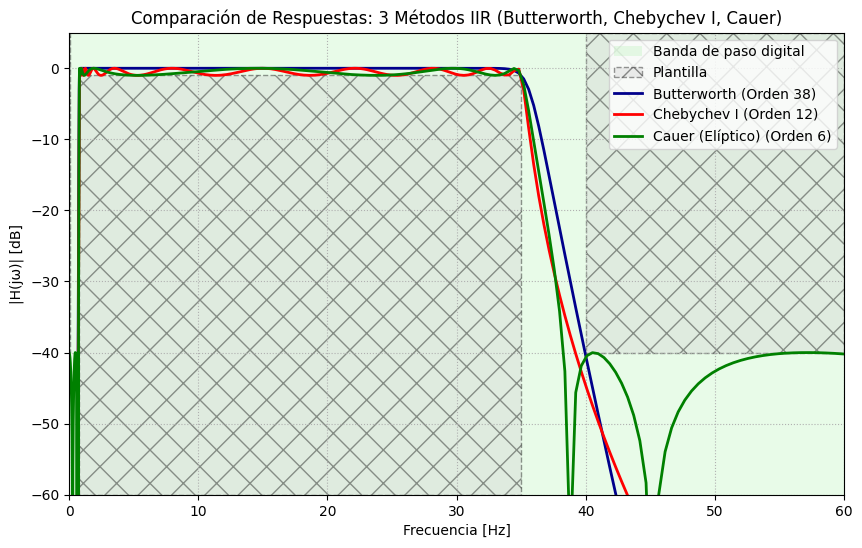

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from pytc2.sistemas_lineales import plot_plantilla 

fs = 1000 # Hz
wp = np.array([0.8, 35])    # Frecuencia de paso (Hz)
ws = np.array([0.1, 40])    # Frecuencia de stop (Hz)
gpass = 1.0                 
gstop = 40.0                
nyq_rate = fs / 2


#Butterworth
orden_b, wn_b = sig.buttord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
sos_b = sig.butter(N=orden_b, Wn=wn_b, btype='bandpass', analog=False, output='sos', fs=fs)
print(f"IIR Butterworth Orden: {orden_b}")

# Cheby1
orden_c1, wn_c1 = sig.cheb1ord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
sos_c1 = sig.cheby1(N=orden_c1, Wn=wn_c1, rp=gpass, btype='bandpass', analog=False, output='sos', fs=fs)
print(f"IIR Chebychev I Orden: {orden_c1}")

# Cauer
orden_e, wn_e = sig.ellipord(wp=wp, ws=ws, gpass=gpass, gstop=gstop, analog=False, fs=fs)
sos_e = sig.ellip(N=orden_e, Wn=wn_e, rp=gpass, rs=gstop, btype='bandpass', analog=False, output='sos', fs=fs)
print(f"IIR Cauer (Elíptico) Orden: {orden_e}")


w_iir, h_b = sig.freqz_sos(sos_b, worN=np.logspace(-2, np.log10(fs/2), 1000), fs=fs)
_, h_c1 = sig.freqz_sos(sos_c1, worN=w_iir, fs=fs)
_, h_e = sig.freqz_sos(sos_e, worN=w_iir, fs=fs)

h_db_b = 20 * np.log10(np.abs(h_b))
h_db_c1 = 20 * np.log10(np.abs(h_c1))
h_db_e = 20 * np.log10(np.abs(h_e))


plt.figure(figsize=(10, 6))
plt.title('Comparación de Respuestas: 3 Métodos IIR (Butterworth, Chebychev I, Cauer)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(jω)| [dB]')
plt.grid(True, which='both', ls=':')
plt.xlim([0, 60])
plt.ylim([-60, 5])

plot_plantilla(
    filter_type='bandpass',
    fpass=wp,
    ripple=gpass,
    fstop=ws,
    attenuation=gstop,
    fs=fs
)

plt.plot(w_iir, h_db_b, color='darkblue', linewidth=2, label=f'Butterworth (Orden {orden_b})')
plt.plot(w_iir, h_db_c1, color='red', linewidth=2, label=f'Chebychev I (Orden {orden_c1})')
plt.plot(w_iir, h_db_e, color='green', linewidth=2, label=f'Cauer (Elíptico) (Orden {orden_e})')

plt.legend(loc='upper right')
plt.show()


El gráfico presenta la comparación de la respuesta en magnitud de tres filtros IIR (Butterworth, Chebychev I y Cauer) diseñados para cumplir la misma plantilla de pasa-banda, permitiendo un análisis directo de su eficiencia en relación con el orden. 

El filtro Cauer, en verde, se ve el más eficiente de los tres, alcanzando el cumplimiento de la plantilla con el orden más bajo (Orden 6). Logra esta eficiencia permitiendo ripple tanto en la banda de paso 1dB como en la banda de rechazo, lo que le confiere la transición más abrupta de todos los IIR.

Le sigue el filtro Chebychev I (rojo), que utiliza un orden intermedio (Orden 12). Este filtro solo permite ripple en la banda de paso, ofreciendo una transición menos abrupta que Cauer, pero mucho más eficiente que Butterworth. Finalmente, el filtro Butterworth (azul), al exigir la máxima planicidad (sin ripple) en la banda de paso, requiere el orden más alto de los tres IIR (Orden 24) para lograr la transición requerida, siendo la aproximación menos eficiente en este contexto.
 
En resumen, este bajo orden de los IIR (6 a 24) contrasta enormemente con los órdenes de más de 2200 requeridos por los filtros FIR para la misma tarea.

**d)  Evalúe el rendimiento de los filtros que haya diseñado:**

1.Verifique que filtra las señales interferentes.

2.Verifique que es inocuo en las zonas donde no hay interferentes.

IIR
Para aplicar los filtros IIR usamos sosfiltfilt, que realiza un filtrado bidireccional. Esto es importante porque al hacer el filtrado hacia adelante y hacia atrás, se anula la fase y se evita la distorsión de fase, que es algo típico en los IIR.

FIR
En el caso de los FIR, directamente aplicamos los filtros usando np.convolve con mode='same'. 

No usamos filtfilt con los FIR porque no es necesario, si el filtro tiene fase lineal, el retardo es constante y no deforma la señal.


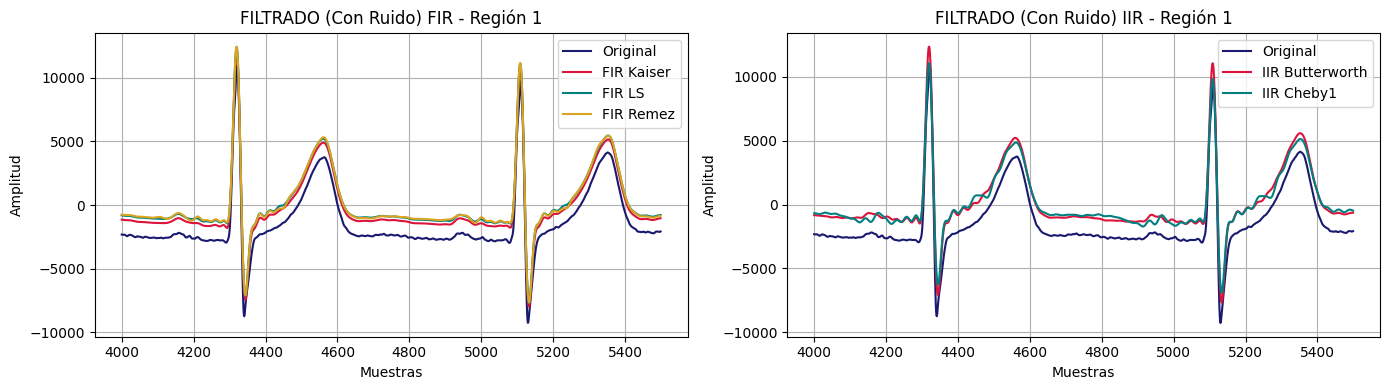

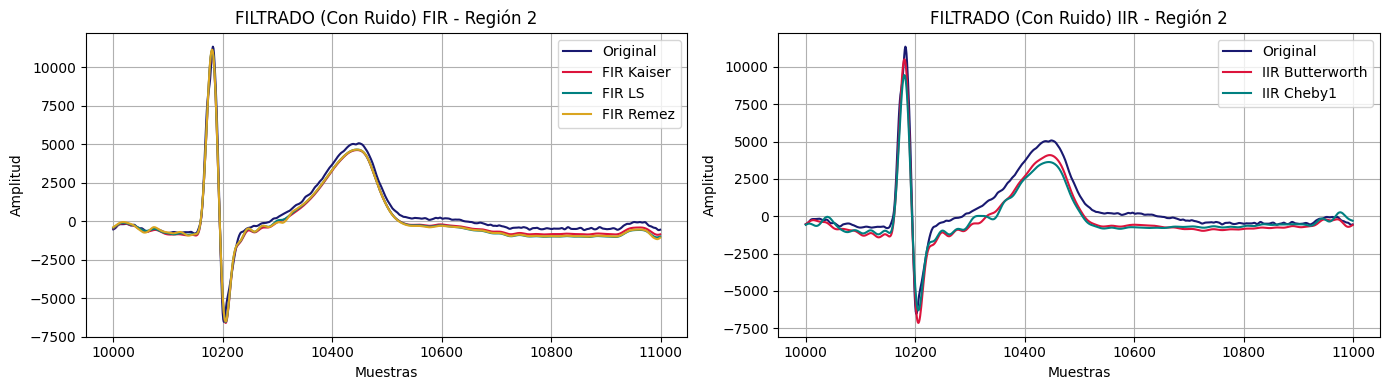

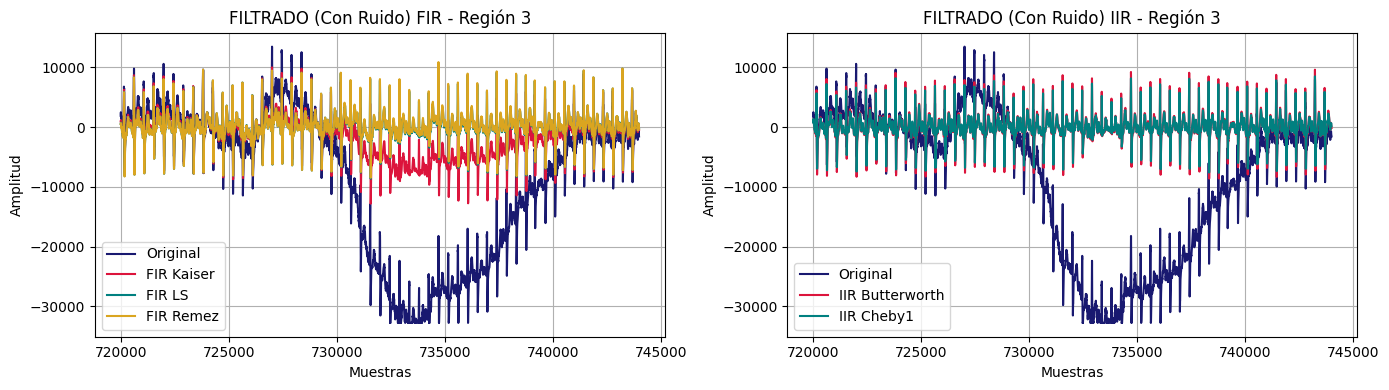

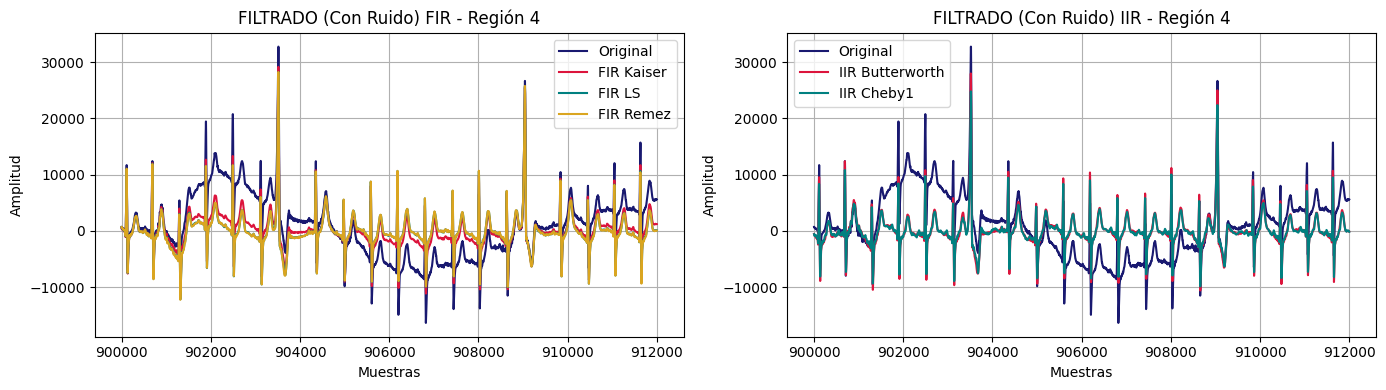

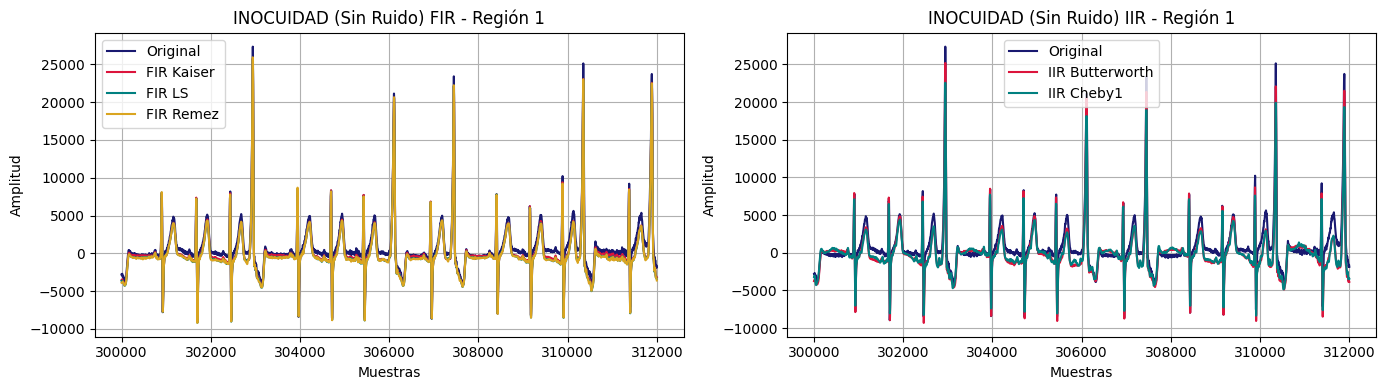

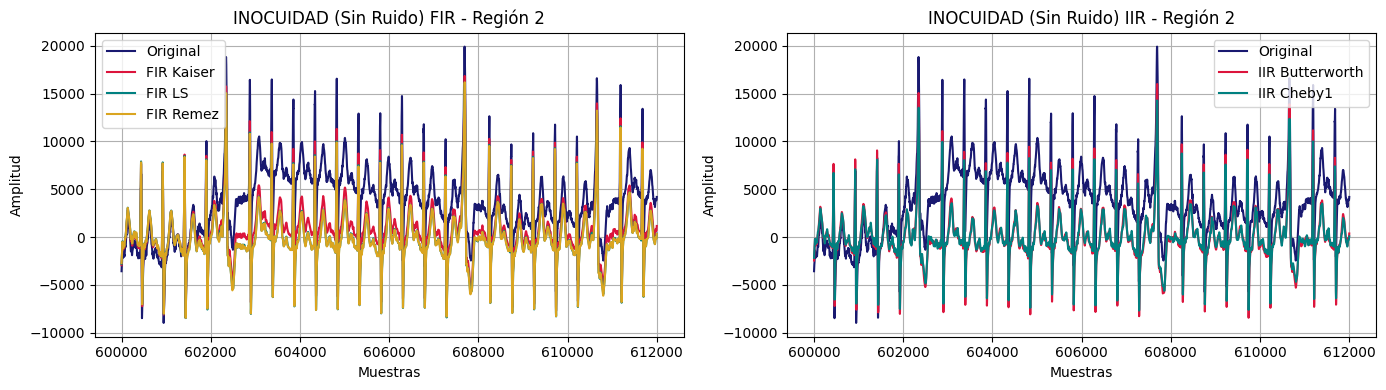

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
import scipy.io as sio

try:
    mat_struct = sio.loadmat('./ECG_TP4.mat')
    ecg_lead = mat_struct['ecg_lead'].flatten() 
except FileNotFoundError:
    print("ADVERTENCIA: Archivo ECG no encontrado. Usando datos de prueba.")
    fs = 1000
    T = 30 # 30 segundos
    t = np.arange(0, T, 1/fs)
    ecg_lead = np.sin(2*np.pi*1*t) + 0.5 * np.sin(2*np.pi*50*t) # ECG + Ruido
    
#APLICACIÓN DE FILTROS

# IIR: usamos sosfiltfilt para tener fase cero (filtrado bidireccional)
ecg_lead_iir_butter = sig.sosfiltfilt(sos_b, ecg_lead)
ecg_lead_iir_cheby = sig.sosfiltfilt(sos_c1, ecg_lead)

# FIR: usamos los coeficientes  en convolve
ecg_lead_fir_k = np.convolve(ecg_lead, fir_kaiser_bandpass, mode='same')
ecg_lead_fir_firls = np.convolve(ecg_lead, fir_firls_bandpass, mode='same')
ecg_lead_fir_remez = np.convolve(ecg_lead, fir_remez_bandpass, mode='same')

# Regiones con alto ruido / interferentes
regs_con_ruido = [
    [4000, 5500],
    [10000, 11000],
    (np.array([12, 12.4]) * 60 * fs).astype(int),
    (np.array([15, 15.2]) * 60 * fs).astype(int)]

# Regiones limpias 
regs_sin_ruido = [
    (np.array([5, 5.2]) * 60 * fs).astype(int),
    (np.array([10, 10.2]) * 60 * fs).astype(int)] 



def plot_comparacion_filtros(ecg_original, ecg_fir_k, ecg_fir_firls, ecg_fir_remez,
                              ecg_iir_butter, ecg_iir_cheby, regiones, titulo_base):
    for i, (start, end) in enumerate(regiones):
        eje_x = np.arange(start, end)
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))
        
        # FIR
        axs[0].plot(eje_x, ecg_original[start:end], label='Original', color='midnightblue')
        axs[0].plot(eje_x, ecg_fir_k[start:end], label='FIR Kaiser', color='crimson')
        axs[0].plot(eje_x, ecg_fir_firls[start:end], label='FIR LS', color='teal')
        axs[0].plot(eje_x, ecg_fir_remez[start:end], label='FIR Remez', color='goldenrod')
        axs[0].set_title(f'{titulo_base} FIR - Región {i+1}')
        axs[0].set_xlabel('Muestras')
        axs[0].set_ylabel('Amplitud')
        axs[0].legend()
        axs[0].grid(True)

        # IIR
        axs[1].plot(eje_x, ecg_original[start:end], label='Original', color='midnightblue')
        axs[1].plot(eje_x, ecg_iir_butter[start:end], label='IIR Butterworth', color='crimson')
        axs[1].plot(eje_x, ecg_iir_cheby[start:end], label='IIR Cheby1', color='teal')
        axs[1].set_title(f'{titulo_base} IIR - Región {i+1}')
        axs[1].set_xlabel('Muestras')
        axs[1].set_ylabel('Amplitud')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()


# FILTRADO (Con Ruido)
plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_con_ruido, 'FILTRADO (Con Ruido)')

# INOCUIDAD
plot_comparacion_filtros(ecg_lead, ecg_lead_fir_k, ecg_lead_fir_firls, ecg_lead_fir_remez,
                         ecg_lead_iir_butter, ecg_lead_iir_cheby, regs_sin_ruido, 'INOCUIDAD (Sin Ruido)')


El proceso de filtrado resultó ser exitoso con ambas familias de filtros, FIR  e IIR.

Pudimos limpiar la señal ECG de manera efectiva. Esto se evidencia porque se corrigió por completo ese corrimiento de la línea de base. Después de pasar la señal por nuestros filtros, la línea de base queda estable y centrada.

Lo más importante es que, al mismo tiempo que eliminamos el ruido, la morfología fundamental de la señal se mantuvo intacta y limpia. 

#### **CONCLUSIÓN** 

Al final de este trabajo, la principal conclusión técnica que queda es sobre la dificultad de implementación.

Los filtros FIR (Respuesta de Impulso Finita) ofrecen una gran ventaja teórica, el retardo de fase es constante y, por lo tanto, son inocuos, nunca deforman la forma de onda del ECG. Sin embargo, en la práctica, su diseño fue complejo. 

Los filtros IIR (Respuesta de Impulso Infinita), por otro lado, fueron la solución fácil y rápida. Con la función iirdesign pudimos obtener una respuesta perfecta con un orden bajísimo y sin casi ningún ajuste fino. El problema de la fase no lineal de los IIR se resolvió usando la técnica de filtrado bidireccional (filtfilt), eliminando la distorsión.

